# 3.1 MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

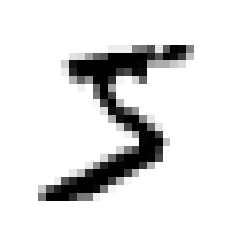

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# some_digit = X[0]     DataFrame数据类型，它在行/列选取时不支持X[0]的取法
some_digit = X.iloc[0]
# some_digit_image = some_digit.reshape(28,28)    #图片是28×28像素，cmap将标量数据映射到色彩图
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

[Pandas中的loc和iloc函数用法](https://wenku.baidu.com/view/d340af4ef6335a8102d276a20029bd64783e62c6.html)

In [6]:
# y[0]
y.iloc[0]

'5'

In [7]:
# 把y转成整数
import numpy as np
y = y.astype(np.uint8)

In [8]:
# 划分训练集、测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 训练二元分类器

In [9]:
# 先只识别一个数字5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# 使用Scikit-Learn的SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# 检测数字5的图片
sgd_clf.predict([some_digit])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 3.3 性能测量

## 3.3.1 使用交叉验证测量准确率

In [12]:
# 用cross_val_score()评估
# 采用K-折叠验证法(将训练集分解成K个折叠，每次留1个折叠进行预测，剩余的训练)

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

## 3.3.2 混淆矩阵

In [13]:
# 思路：统计A类别实例被分为B类别实列的次数

In [14]:
# cross_val_predict()函数返回每个折叠的预测
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
# 使用confusion_matrics()函数获取混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

真负TN(左上)、假正FP(右上)、假负FN(左下)、真正TP(右下)  
精度=TP/TP+FP  
召回率=TP/TP+FN  

## 3.3.3 精度和召回率

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [18]:
# F1分数
# F1 = 2×((精度×召回率)/(精度+召回率))

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.3.4 精度/召回率权衡

在精度/召回率权衡中，图像按其分类器评分进行排名，而高于所选决策阈值的图片被认为是正的；  
阈值越高，召回率越低；  
但是(通常)精度越高

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

如何决定使用什么阈值？

In [21]:
# 使用cross_val_predict()函数获取训练集中所有实例的分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
# 使用precision_recall_curve()函数来计算所有可能的阈值的精度和召回率
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

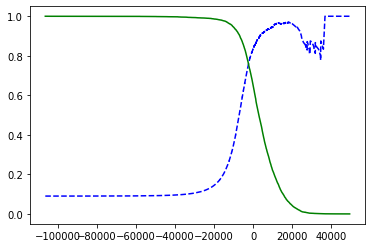

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
# 讲精度设为90%

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # np.argmax()会返回最大值的第一个索引
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC曲线

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

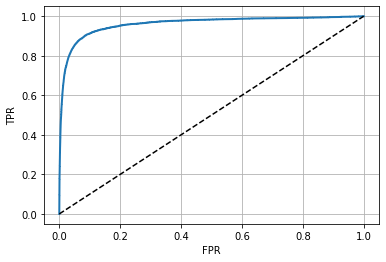

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(b=None, which='major', axis='both')

plot_roc_curve(fpr, tpr)
plt.show()


In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [30]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

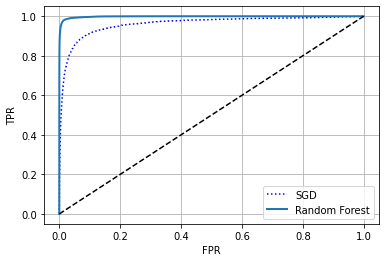

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# 3.4 多类分类器

二元分类器实现多类分类  
1. OvR(*one-versus-reverse*): 分为10类就训练10个二元分类器
2. OvO(*one-versus-one*): 如果存在N个类别，就训练N*(N-1)/2个分类器

In [32]:
# sklearn检测到使用二元分类算法进行多类分类任务，会根据情况自动运行OvR或OvO

# SVM分类器 内部OvO
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [33]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [34]:
# 当训练分类器时，目标类的列表会存储在classes_属性中
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
# 强制使用OvR
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train) 训练太慢！！！
# ovr_clf.predict([some_digit])

In [36]:
# 训练SGDClassifier或者RandomForestClassifier, 不必运行OvR或者OvO, 直接分为多类
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [38]:
# 每个实例分类为每个类的概率列表
sgd_clf.decision_function([some_digit])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
# 评估SGDClassifier的准确性
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
# 将输入进行简单放缩，提示准确率
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5 误差分析

In [41]:
# 混淆矩阵
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

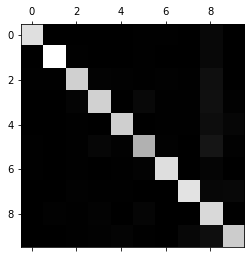

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# 5较暗，可能数字5的图片较少

In [43]:
# 得到错误率而不是错误的绝对值
# 将矩阵中的每个值除以相应类中的图片数量

row_sums = conf_mx.sum(axis=1, keepdims=True)   # keepdims=True, 保持结果的维度与原始array相同
norm_conf_mx = conf_mx / row_sums

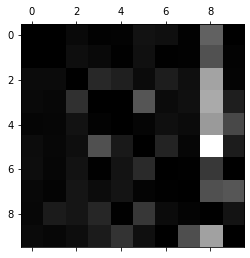

In [49]:
# 用0填充对角线，只保留错误，重新绘制结果
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 每行代表实际类，每列代表预测类
# 很多图片被错误地分类为数字8

# 3.7 多标签分类

In [50]:
# 创建一个y_multilabel数组，其中包含两个数字图片地目标标签
# 第一个表示数字是否>=7, 第二个表示是否为奇数

from sklearn.neighbors import KNeighborsClassifier      # 支持多标签分类

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]    #np.c_可以拼接多个数组，要求待拼接的多个数组的行数必须相同

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [52]:
# F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

[多类分类性能评价之宏平均(macro-average)与微平均(micro-average)](https://wenku.baidu.com/view/c04c135959cfa1c7aa00b52acfc789eb172d9e78.html)

# 3.7 多输出分类

输入一张有噪声的照片，输出一张干净的照片

In [54]:
noise = np.random.randint(0, 100, size=(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, size=(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

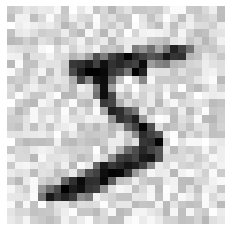

In [55]:
# 有噪声的输入图片
mod_digit = X_train_mod.iloc[0]
mod_digit_image = mod_digit.values.reshape(28,28)

plt.imshow(mod_digit_image, cmap="binary")
plt.axis("off")
plt.show()

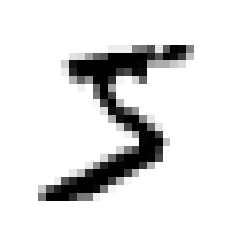

In [56]:
# 目标的干净图片
clean_digit = y_train_mod.iloc[0]
clean_digit_image = clean_digit.values.reshape(28,28)

plt.imshow(clean_digit_image, cmap="binary")
plt.axis("off")
plt.show()

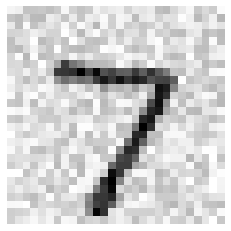

In [93]:
plt.imshow(X_test_mod.iloc[0].values.reshape(28,28), cmap="binary")
plt.axis("off")
plt.show()

In [91]:
# Train
knn_clf.fit(X_train_mod, y_train_mod)
clean_pic = knn_clf.predict([X_test_mod.iloc[0]])

C:\Users\李子豪\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


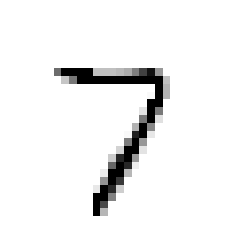

In [92]:
# clean_pic = clean_pic.values.reshape(28,28)   'numpy.ndarray' object has no attribute 'values'
clean_pic = clean_pic.reshape(28,28)
plt.imshow(clean_pic, cmap="binary")
plt.axis("off")
plt.show()